<a href="https://colab.research.google.com/github/rohinishimpatwar/DeepLearning/blob/master/Assignment4-DeepLearning/FaceNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 9.3MB/s 


In [0]:

import mtcnn
# print version
print(mtcnn.__version__)

Using TensorFlow backend.


0.1.0


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 # opencv
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("/content/drive/My Drive/DeepLearningSem3/input/FacenetData/5-celebrity-faces-dataset"))

['val', 'train', 'data']


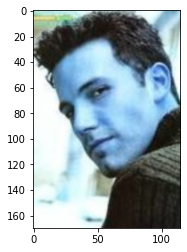

(170, 115, 3)


In [0]:
img = cv2.imread('/content/drive/My Drive/DeepLearningSem3/input/FacenetData/5-celebrity-faces-dataset/data/train/ben_afflek/httpcsvkmeuaeccjpg.jpg')
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
#plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()
print(img.shape)

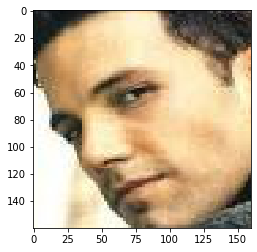

(160, 160, 3)


In [0]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # deal with negative pixel index
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

# load the photo and extract the face
pixels = extract_face('/content/drive/My Drive/DeepLearningSem3/input/FacenetData/5-celebrity-faces-dataset/data/train/ben_afflek/httpcsvkmeuaeccjpg.jpg')
plt.imshow(pixels)
plt.show()
print(pixels.shape)


**Apply extract_face() for all faces in the dataset**

In [0]:
def load_face(dir):
    faces = list()
    # enumerate files
    for filename in os.listdir(dir):
        path = dir + filename
        face = extract_face(path)
        faces.append(face)
    return faces

def load_dataset(dir):
    # list for faces and labels
    X, y = list(), list()
    for subdir in os.listdir(dir):
        path = dir + subdir + '/'
        faces = load_face(path)
        labels = [subdir for i in range(len(faces))]
        print("loaded %d sample for class: %s" % (len(faces),subdir) ) # print progress
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)


# load train dataset
trainX, trainy = load_dataset('/content/drive/My Drive/DeepLearningSem3/input/FacenetData/5-celebrity-faces-dataset/data/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('/content/drive/My Drive/DeepLearningSem3/input/FacenetData/5-celebrity-faces-dataset/data/val/')
print(testX.shape, testy.shape)

# save and compress the dataset for further use
np.savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

loaded 14 sample for class: ben_afflek
loaded 17 sample for class: elton_john
loaded 21 sample for class: jerry_seinfeld
loaded 22 sample for class: mindy_kaling
loaded 19 sample for class: madonna
(93, 160, 160, 3) (93,)
loaded 5 sample for class: elton_john
loaded 5 sample for class: ben_afflek
loaded 5 sample for class: jerry_seinfeld
loaded 5 sample for class: madonna
loaded 5 sample for class: mindy_kaling
(25, 160, 160, 3) (25,)


In [0]:
# load the face dataset
data = np.load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)


In [0]:

# load the facenet model
facenet_model = load_model('facenet_keras.h5')
print('Loaded Model')

OSError: ignored

**Next step is standardizing the faces and extracting a embedding vector using the model**

In [0]:
def get_embedding(model, face):
    # scale pixel values
    face = face.astype('float32')
    # standardization
    mean, std = face.mean(), face.std()
    face = (face-mean)/std
    # transfer face into one sample (3 dimension to 4 dimension)
    sample = np.expand_dims(face, axis=0)
    # make prediction to get embedding
    yhat = model.predict(sample)
    return yhat[0]
    
# convert each face in the train set into embedding
emdTrainX = list()
for face in trainX:
    emd = get_embedding(facenet_model, face)
    emdTrainX.append(emd)
    
emdTrainX = np.asarray(emdTrainX)
print(emdTrainX.shape)

# convert each face in the test set into embedding
emdTestX = list()
for face in testX:
    emd = get_embedding(facenet_model, face)
    emdTestX.append(emd)
emdTestX = np.asarray(emdTestX)
print(emdTestX.shape)

# save arrays to one file in compressed format
np.savez_compressed('5-celebrity-faces-embeddings.npz', emdTrainX, trainy, emdTestX, testy)

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

print("Dataset: train=%d, test=%d" % (emdTrainX.shape[0], emdTestX.shape[0]))
# normalize input vectors
in_encoder = Normalizer()
emdTrainX_norm = in_encoder.transform(emdTrainX)
emdTestX_norm = in_encoder.transform(emdTestX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy_enc = out_encoder.transform(trainy)
testy_enc = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX_norm, trainy_enc)
# predict
yhat_train = model.predict(emdTrainX_norm)
yhat_test = model.predict(emdTestX_norm)
# score
score_train = accuracy_score(trainy_enc, yhat_train)
score_test = accuracy_score(testy_enc, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))